In [17]:
# TODO B delete some of these


import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy
import csv

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import pdist, squareform

import math
from time import time

import matplotlib.lines as lines

## %matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

In [18]:
# edgelists
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz")
follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")

cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)

# reading in the master dataset about graphs
tract_df = pd.read_csv('../data/network_properties.csv') ### PAY ATTENTION TRACT INSTEAD OF TRACTS!!!!
# new versionwithout two degrees - old: graph_properties

# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# Cartesian coordinate projection of tract centroids
tract_geoms['centroid'] = tract_geoms['geometry'].centroid
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

counties = gpd.read_file('../data/tl_2012_us_county.shp') # KERDES

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
# add city names to edgelists
cbsacode['city'] = cbsacode["short_name"].map(lambda s: s.split("/")[0].replace(' ','_').replace('.','').lower())
mobility = pd.merge(mobility, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
mobility = mobility.drop(columns = ['geoid'])
follow_hh = pd.merge(follow_hh, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
follow_hh = follow_hh.drop(columns = ['geoid'])
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

In [20]:
# adding normal city names
city_dict = dict(zip(cbsacode['city'],cbsacode['short_name']))
tract_df['short_name'] = tract_df['city'].map(city_dict)

In [21]:
# merge networks and coodrdinates

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_work', right_on='full_geoid',how='left') # on work
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_work", "geometry": "polygon_work"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home_0
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home_1', right_on='full_geoid',how='left') # on home_1
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home_1", "geometry": "polygon_home_1"})

# Functions

In [22]:
# Consensus community map drawer
def community_map(city, g_type, algorithm_type, tract_df):
    """
    For a given network and algorithm used for calculating communities,
    it draws the colored community map eith tract boundaries.
    
    It uses the previously loaded `tract_geoms` GeoDataFrame in which geometrical data is stored,
    and `tract_df` pandas.DataFrames, in which consensus clustering labels are stored.
    
    Parameters:
    -----------
    city : str
        name of the city, lowercase, '_' instead of ' '
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    algorithm_type : str
        either 'ms' as clustering (community finding) based on Expert et al.(2011) whose clustering algorithm uses a spatial null model
        or 'mgn' as clustering based on Newman-Girwan algortihm (which equals the Louvain)
        
    tract_df : pd.DataFrame
        contains community labels for each tract
        
    Returns:
    --------
    
    plot the map and save it to figures
        
    """
    
    # filter data to the given network's given communities
    map_df = deepcopy(tract_df[ (tract_df['city'] == city) & (tract_df['g_type'] == g_type) & (tract_df['algorithm_type'] == algorithm_type)])
    # merge to geodata
    map_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], map_df, left_on='full_geoid', right_on='geoid')
    
    # colormap - uses 9 colors <-- this is the number of communities in the network with most communities
    cmap = matplotlib.colors.ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
    
    f, ax = plt.subplots(1, figsize=(16,12))
    map_tracts.plot(ax=ax, column = 'S_cons', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax, color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax.set_axis_off()
    if algorithm_type == 'ms':
        alg = 'Expert et al.(2011) algorithm'
    elif algorithm_type == 'mgn':
            alg = 'Newman-Girvan algorithm'
    title = city + 's communities using ' + alg # KERDES apostroph
    plt.title(title, size = 20)
    plt.show()
    filename = 'consen_communities_' + g_type + '_' + algorithm_type
    # savefig(filename, dpi=1200, bbox_inches='tight')

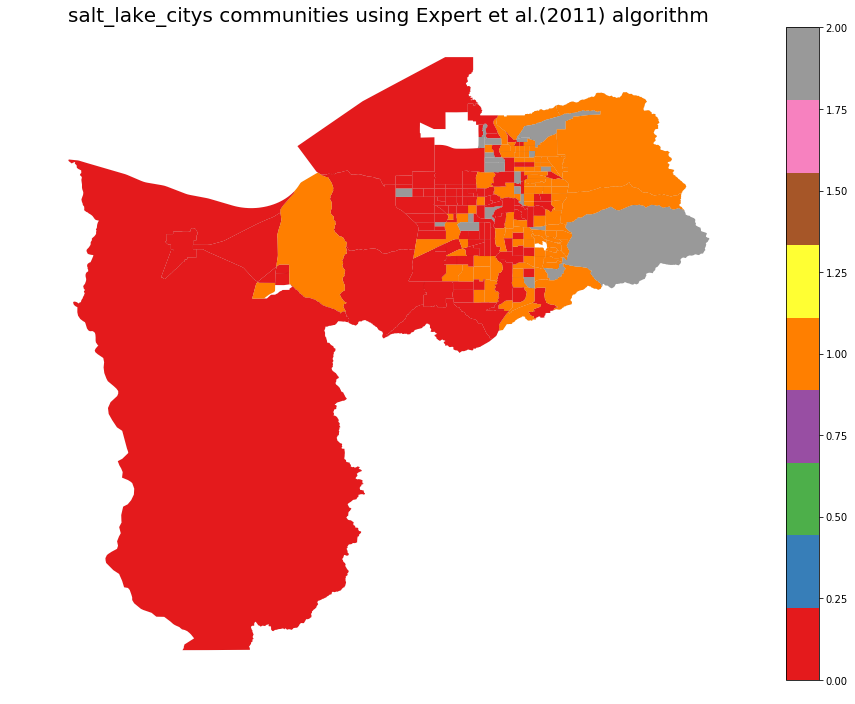

In [23]:
community_map('salt_lake_city','fol_hh','ms', tract_df)

### Degree distribution

In [107]:
def degree_dist_histograms(city):
    
    fig,ax=plt.subplots(1,1,figsize=(8,6))
    title = 'Degree distribution of networks in ' + city
    fig.suptitle(title, fontsize=20)

    # data to plot
    degree_mob = tract_df[(tract_df['g_type'] == 'mob') & (tract_df['short_name'] == city)]['degree']
    degree_fol_hh = tract_df[(tract_df['g_type'] == 'fol_hh') & (tract_df['short_name'] == city)]['degree']

    ax.hist(degree_mob, bins=50, color = 'green', histtype='step', label = 'fafda')
    ax.hist(degree_fol_hh, bins=50, color = 'darkblue', histtype='step')
    ax.set_xlabel('Degree', size = 14)
    ax.set_ylabel('No. of tracts', size = 14)
    ax.grid()

    plt.show()
    figname = 'degree_dist_' + city
    # savefig(figname, dpi=1200, bbox_inches='tight')

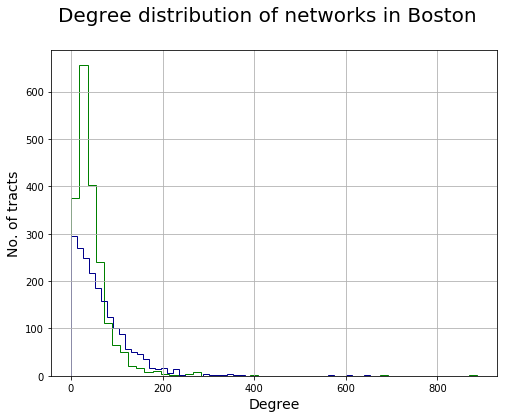

In [108]:
degree_dist_histograms('Boston')

(array([376., 656., 402., 240., 112.,  66.,  50.,  20.,  16.,   8.,  10.,
          4.,   2.,   2.,   4.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([  1.  ,  18.72,  36.44,  54.16,  71.88,  89.6 , 107.32, 125.04,
        142.76, 160.48, 178.2 , 195.92, 213.64, 231.36, 249.08, 266.8 ,
        284.52, 302.24, 319.96, 337.68, 355.4 , 373.12, 390.84, 408.56,
        426.28, 444.  , 461.72, 479.44, 497.16, 514.88, 532.6 , 550.32,
        568.04, 585.76, 603.48, 621.2 , 638.92, 656.64, 674.36, 692.08,
        709.8 , 727.52, 745.24, 762.96, 780.68, 798.4 , 816.12, 833.84,
        851.56, 869.28, 887.  ]),
 <a list of 50 Patch objects>)

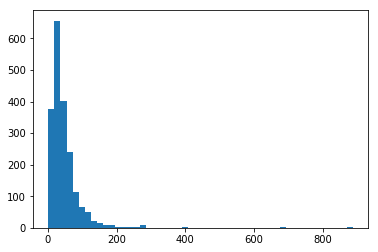

In [51]:
city = 'boston'
degree_mob = tract_df[(tract_df['g_type'] == 'mob') & (tract_df['city'] == city)]['degree']
plt.hist(degree_mob, bins=50)

In [8]:
# create edge lines
def line(x,y):
    return LineString([x,y])

In [9]:
def degree_bubble_map(city, g_type, mobility, follow_hh):
    # Create edge lines
    # geometry = edges between 
    # - home and work centroids
    # - homes of follower pairs tracts' centroids
    
    # filter for the city
    mobility = deepcopy(mobility['city'] == 'city')
    follow_hh = deepcopy(follow_hh['city'] == 'city')
    
    mobility['geometry'] = mobility.apply(lambda row: line(row['centroid_home'],row['centroid_work'])) # KERDES MIERT KELL? ,axis=1)
    follow_hh['geometry'] = follow_hh.apply(lambda row: line(row['centroid_home'],row['centroid_home_1'])) #,axis=1) 

    # convert into GeoDataFrame
    gdf_mobility = GeoDataFrame(mobility, crs="EPSG:4326")
    gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

    # GeoDataFrames for the bubbles
    gdf_mobility_home = gdf_mobility.set_geometry('centroid_home')
    gdf_mobility_work = gdf_mobility.set_geometry('centroid_work')
    gdf_follow_hh_home = gdf_follow_hh.set_geometry('centroid_home')

    
    # Draw figure
    f, ax = plt.subplots(1, figsize=(32,16))

    if g_type == 'mob':

        gdf_mobility.plot(ax=ax, alpha=0.1, linewidth=gdf_mobility['cnt']*0.3, color='black')
        gdf_mobility_home.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_home['cnt']*3, color='blue')
        gdf_mobility_work.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_work['cnt']*3, color='yellow')

    elif g_type == 'fol_hh':

        gdf_follow_hh.plot(ax=ax, alpha=0.1, linewidth = gdf_follow_hh['cnt']*0.3, color='grey')
        #gdf_follow_hh_home.plot(ax=ax, alpha=0.2, markersize = gdf_follow_hh_home['degree_fol_hh'].astype('float'), color='blue')
        # TODO
    ax.set_axis_off()
    plt.show()

    # TODO CHECK AND CORRECT SIZES

In [10]:
degree_bubble_map('boston', 'mob', mobility, follow_hh)

TypeError: 'bool' object is not subscriptable

In [11]:
mobility.head()

,cbsacode,tract_home,tract_work,cnt,city,short_name,polygon_home,centroid_home,polygon_work,centroid_work
0,14460,14000US25017353300,14000US25025070200,2,boston,Boston,"POLYGON ((-71.11716 42.35700, -71.11707 42.357...",POINT (-71.11148 42.35845),"POLYGON ((-71.06803 42.34798, -71.06661 42.348...",POINT (-71.06393 42.34966)
1,14460,14000US25017353300,14000US25025070101,1,boston,Boston,"POLYGON ((-71.11716 42.35700, -71.11707 42.357...",POINT (-71.11148 42.35845),"POLYGON ((-71.06456 42.35238, -71.06413 42.353...",POINT (-71.05727 42.35242)
2,14460,14000US25017353300,14000US25025000803,1,boston,Boston,"POLYGON ((-71.11716 42.35700, -71.11707 42.357...",POINT (-71.11148 42.35845),"POLYGON ((-71.13128 42.35616, -71.12318 42.359...",POINT (-71.12128 42.35946)
3,14460,14000US25017353300,14000US25025000100,1,boston,Boston,"POLYGON ((-71.11716 42.35700, -71.11707 42.357...",POINT (-71.11148 42.35845),"POLYGON ((-71.16090 42.35863, -71.16003 42.358...",POINT (-71.13859 42.36149)
4,14460,14000US25017353300,14000US25017353800,1,boston,Boston,"POLYGON ((-71.11716 42.35700, -71.11707 42.357...",POINT (-71.11148 42.35845),"POLYGON ((-71.11391 42.37084, -71.11350 42.371...",POINT (-71.10971 42.37039)


In [12]:
size(tract_df)

9389280

In [14]:
151440*4

605760

In [13]:
tract_df # 600396 rows × 61 columns

,geoid,S_cons,city,algorithm_type,g_type,modularity,tracts_in_network,sum_tracts,county,nmi_to_counties,...,black_error_2,native_2,native_error_2,asian_2,asian_error_2,income_growth,income_growth_p,clean_name,population_1_city_sum,short_name
0,14000US36005021800,0,new_york,ms,mob,0.411038,4603,4609,5,0.368244,...,688,0,16,159,161,2345.0,0.141129,new_york,19533801,New York
1,14000US36005021800,0,new_york,mgn,mob,0.516811,4603,4609,5,0.533273,...,688,0,16,159,161,2345.0,0.141129,new_york,19533801,New York
2,14000US36005021800,4,new_york,ms,fol_hh,0.371920,4389,4609,5,0.302133,...,688,0,16,159,161,2345.0,0.141129,new_york,19533801,New York
3,14000US36005021800,4,new_york,mgn,fol_hh,0.463110,4389,4609,5,0.444802,...,688,0,16,159,161,2345.0,0.141129,new_york,19533801,New York
4,14000US36005026500,0,new_york,ms,mob,0.411038,4603,4609,5,0.368244,...,440,0,16,485,310,689.0,0.051645,new_york,19533801,New York
5,14000US36005026500,0,new_york,mgn,mob,0.516811,4603,4609,5,0.533273,...,440,0,16,485,310,689.0,0.051645,new_york,19533801,New York
6,14000US36005026500,3,new_york,ms,fol_hh,0.371920,4389,4609,5,0.302133,...,440,0,16,485,310,689.0,0.051645,new_york,19533801,New York
7,14000US36005026500,3,new_york,mgn,fol_hh,0.463110,4389,4609,5,0.444802,...,440,0,16,485,310,689.0,0.051645,new_york,19533801,New York
8,14000US36047016000,1,new_york,ms,mob,0.411038,4603,4609,47,0.368244,...,100,0,11,758,140,-257.0,-0.007927,new_york,19533801,New York
9,14000US36047016000,0,new_york,mgn,mob,0.516811,4603,4609,47,0.533273,...,100,0,11,758,140,-257.0,-0.007927,new_york,19533801,New York


# Aggregate plots

In [25]:
# Aggregate dataframe for sorting boxplot drawing

# by network
network_df = tract_df.groupby(['short_name','g_type'])['short_name','g_type','density', 'population_1_city_sum'].mean().reset_index()

# by community
community_df = tract_df.groupby(['short_name', 'g_type', 'algorithm_type', 'S_cons']).mean() # KERDES EZ MMIERT MUKODIK??

In [27]:
# sort by total population
network_df = network_df.sort_values(by=['population_1_city_sum'])

In [28]:
def sorting(df_grouped, by):
    sorted_parts = list(df_grouped.sort_values(by = by, ascending = False).index)
    return sorted_parts

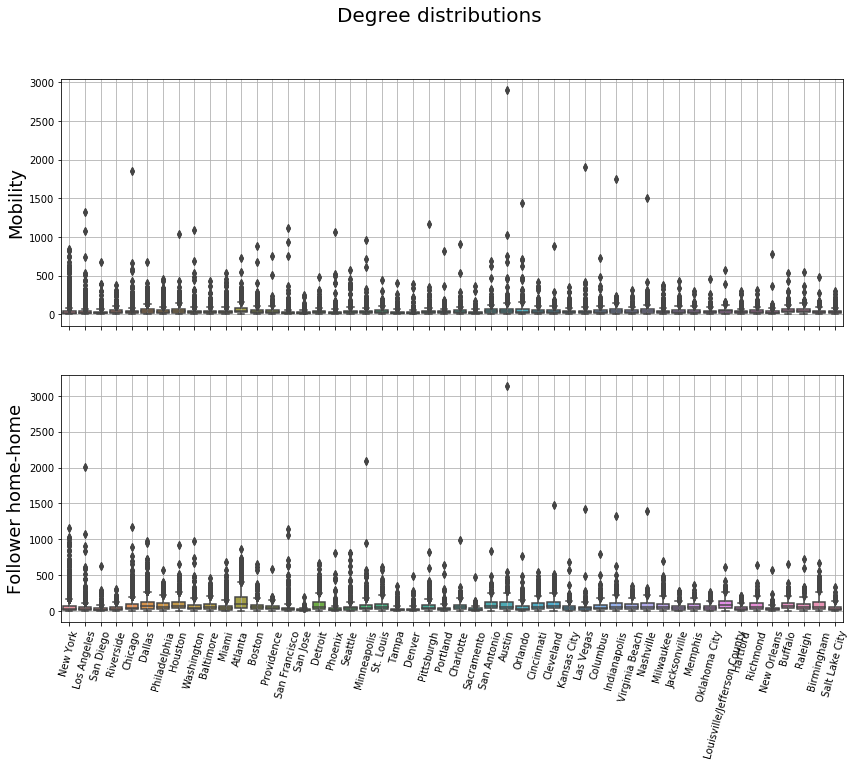

In [31]:
# JAVITANI
fig,ax=plt.subplots(2,1,sharex=True,figsize=(14,10))
fig.suptitle('Degree distributions', fontsize=20)

x = 'short_name' # city
y = 'degree'

#sorted_parts_mob = sorting(community_df[community_df['g_type'] == 'mob'], y)
#sorted_parts_fol_hh = sorting(community_df[community_df['g_type'] == 'fol_hh'], y)

sns.boxplot(ax = ax[0], x = x, y = y, data = tract_df[tract_df['g_type'] == 'mob'])#.set_xticklabels(labels = tract_df[tract_df['g_type'] == 'mob']['city'], rotation=30) #, order = sorted_parts) #KERDES - UGYANAZOK A SZINEK
# ax[0].set_title('Mobility')
ax[0].set_xlabel('')
ax[0].set_ylabel('Mobility', size = 18)
city_l = list(tract_df[tract_df['g_type'] == 'mob']['short_name'].unique()) # KERDES EZT HASZNALHATOM??????
ax[0].set_xticklabels(city_l, rotation = 75)
ax[0].grid()

sns.boxplot(ax = ax[1], x = x, y = y, data = tract_df[tract_df['g_type'] == 'fol_hh']) #, order = sorted_parts_lw)
#ax[1].set_title('Follower home-home')
ax[1].set_xlabel('')
ax[1].set_ylabel('Follower home-home', size = 18)
city_l = list(tract_df[tract_df['g_type'] == 'fol_hh']['short_name'].unique()) # KERDES EZT HASZNALHATOM??????
ax[1].set_xticklabels(city_l, rotation = 75)
ax[1].grid()

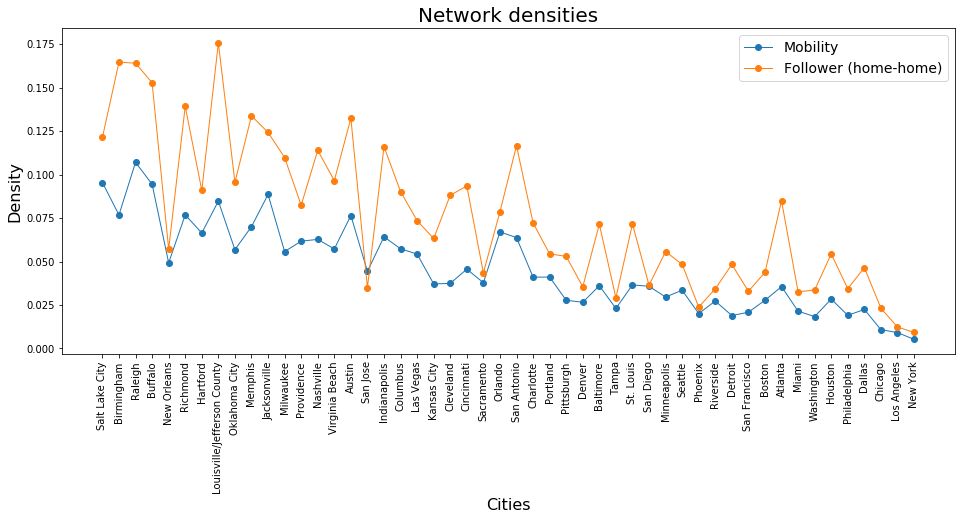

In [42]:
plt.subplots(figsize=(16, 6))

plt.plot(network_df[network_df['g_type'] == 'mob']['short_name'], network_df[network_df['g_type'] == 'mob']['density'], label = 'Mobility', marker='o', linewidth = 1)
plt.plot(network_df[network_df['g_type'] == 'fol_hh']['short_name'], network_df[network_df['g_type'] == 'fol_hh']['density'], label = 'Follower (home-home)', marker='o', linewidth = 1)

plt.xlabel('Cities', size = 16)
plt.ylabel('Density', size = 16)
plt.legend(loc='upper right', fontsize = 14)
plt.xticks(network_df[network_df['g_type'] == 'mob']['short_name'], rotation = 90) # same order in fol_hh
plt.title('Network densities', size = 20)
plt.show()

# depreciated

In [31]:
city = 'boston' # should be a clean name - all lowercase, containing '_' instead of ' '

In [32]:
city_mob_ms_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'mob') & (df['algorithm_type'] == 'ms')])
city_mob_mgn_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'mob') & (df['algorithm_type'] == 'mgn')])
city_fol_hh_ms_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'fol_hh') & (df['algorithm_type'] == 'ms')])
city_fol_hh_mgn_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'fol_hh') & (df['algorithm_type'] == 'mgn')])

In [33]:
city_mob_ms_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_mob_ms_df, left_on='full_geoid', right_on='geoid')
city_mob_mgn_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_mob_mgn_df, left_on='full_geoid', right_on='geoid')
city_fol_hh_ms_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_fol_hh_ms_df, left_on='full_geoid', right_on='geoid')
city_fol_hh_mgn_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_fol_hh_mgn_df, left_on='full_geoid', right_on='geoid')

city_mob_ms_tracts = city_mob_ms_tracts.drop(columns='full_geoid')
city_mob_mgn_tracts = city_mob_mgn_tracts.drop(columns='full_geoid')
city_fol_hh_ms_tracts = city_fol_hh_ms_tracts.drop(columns='full_geoid')
city_fol_hh_mgn_tracts = city_fol_hh_mgn_tracts.drop(columns='full_geoid')

In [43]:
max(df.S_cons) # --> 9 colors in colormap 

8

### Consensus communities on maps

In [55]:
# uses 9 colors <-- this is the number of communities in the network with most communities
cmap = matplotlib.colors.ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])

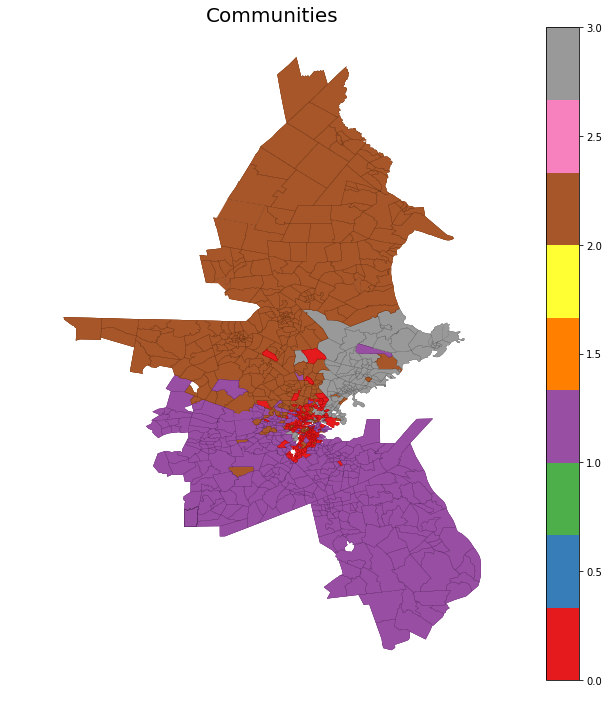

In [56]:
# g_type : mobility
# algorthm_type : Expert

f, ax = plt.subplots(1, figsize=(16,12))
city_mob_ms_tracts.plot(ax=ax, column = 'S_cons', cmap=cmap, legend=True)
city_mob_ms_tracts.boundary.plot(ax=ax, color='black', linewidth=0.015)
#city_mob_mgn_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
ax.set_axis_off()
plt.title('Communities', size=20)
plt.show()

# savefig('consen_communities_mob_ms', dpi=1200, bbox_inches='tight')

In [ ]:
gdf_mobility = GeoDataFrame(mobility, crs="EPSG:4326")
gdf_follow_ww = GeoDataFrame(follow_ww, crs="EPSG:4326")
gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

In [ ]:
gdf_mobility_home = gdf_mobility.set_geometry('centroid_home')
gdf_mobility_work = gdf_mobility.set_geometry('centroid_work')

In [ ]:
# térképes, pöttyös

f, ax = plt.subplots(1, figsize=(32,16))
boston_tracts_all.boundary.plot(ax=ax)
gdf_mobility.plot(ax=ax, alpha=0.1, linewidth=gdf_mobility['cnt']*0.3, color='black')
gdf_mobility_home.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_home['cnt']*3, color='blue')
gdf_mobility_work.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_work['cnt']*3, color='yellow')
ax.set_axis_off()
plt.show()